In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fibheap import FibonacciHeap as FibHeap
from peel_by_motif import *
from utils import *

import random
import pandas as pd
from datetime import datetime
from compare_algs.greedy_algorithms import *
import graph_tool.all as gt

In [2]:

plt.rcParams.update({'font.size': 14})

# Read data

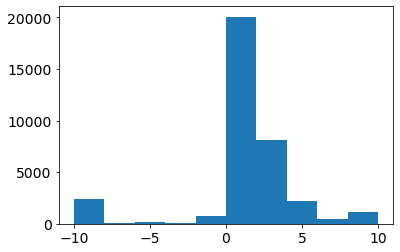

In [3]:
df = pd.read_csv('data/soc-sign-bitcoinotc.csv', names=['source','sink','rate','time'])
G = nx.from_pandas_edgelist(df, 'source', 'sink',['rate'], create_using=nx.DiGraph())
total_vs = plt.hist(df['rate'])
plt.show()

In [4]:
len(G.nodes), len(G.edges)

(5881, 35592)

In [5]:
index = 0
gt_node_map = {}
for n in G.nodes:
    gt_node_map[n] = index
    index += 1
g = gt.Graph()
for row in df[['source','sink','rate']].values:
    g.add_edge(gt_node_map[row[0]], gt_node_map[row[1]])

# Count motifs of size 3 and display

In [6]:
start=datetime.now()
motif3 = gt.motifs(g, 3, return_maps=True)
print(datetime.now()-start)

0:00:17.308417


0 153801


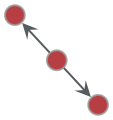

1 36648


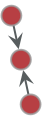

2 65143


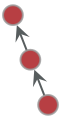

3 3706


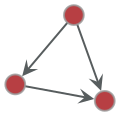

4 440712


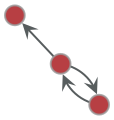

5 169731


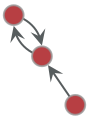

6 79


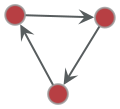

7 2910


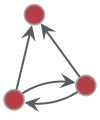

8 2048


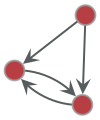

9 729665


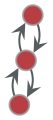

10 1621


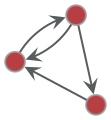

11 9377


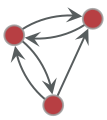

12 13752


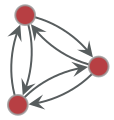

In [21]:
i = 0


for motif_shape in motif3[0]:
    print(i, motif3[1][i])
    i += 1
    pos = gt.sfdp_layout(motif_shape)
    gt.graph_draw(motif_shape,pos,output_size=(60,60))
#     gt.graph_draw(motif_shape,pos,output_size=(60,60), output='figs/motif/3motif_'+str(i)+'.pdf')
#     plt.savefig('figs/motif/3motif_'+str(i)+'.png')
    plt.show()

In [6]:
num_labeled_G = nx.relabel_nodes(G, gt_node_map)

# Compare motif occurance histogram between original graph and the configuration model

In [7]:
import random
indeg = [i[1] for i in G.in_degree]
outdeg = [i[1] for i in G.out_degree]
lamd = sum([i*j for i in indeg for j in outdeg])/2/len(G.edges)

rand_G = gt.Graph()
rand_G.add_vertex((len(indeg)))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G.add_edge(i,j)
rand_motif3 = gt.motifs(rand_G, 3)

[]

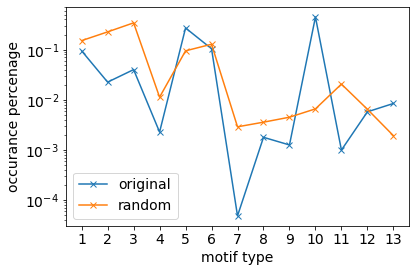

In [8]:
plt.plot([str(i) for i in range(1,14)], [i/sum(motif3[1]) for i in motif3[1]],marker='x',label='original')
plt.plot([str(i) for i in range(1,14)], [i/sum(rand_motif3[1]) for i in rand_motif3[1]],marker='x',label='random')
plt.yscale('log')
plt.xlabel('motif type')
plt.ylabel('occurance percenage')
plt.legend()
plt.tight_layout()
plt.savefig('figs/bitcoin_otc/compare_random.png')
plt.plot()

# Peeling three times (remove peeled subgraph and iterate)

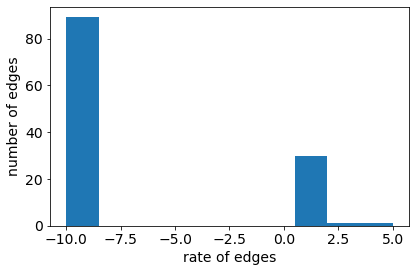

<ipython-input-24-283d0267bcef>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


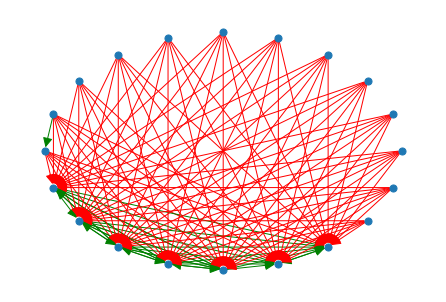

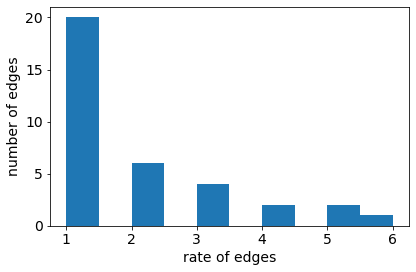

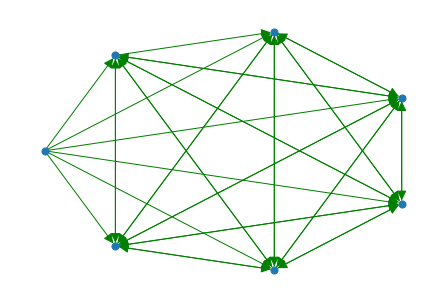

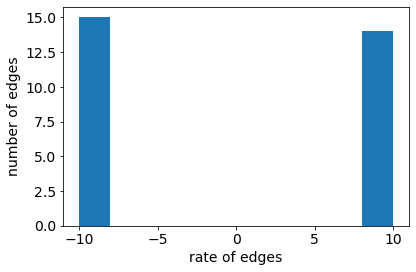

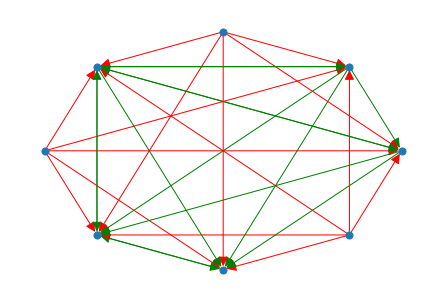

In [24]:
h_list = []
removed_nodes = []
pairs= [([list(i) for i in motif3[2][8]],1),([list(i) for i in motif3[2][9]],-1)]
for i in range(3):
#     print('!!', len(pairs[0][0]))
    node_d, fibheap = init_heap_and_dict(pairs)
    results = peel_by_motif(node_d, fibheap, pairs, 1, False)
    H = num_labeled_G.subgraph(results[1])
    removed_nodes += list(H.nodes)
    h_list.append(H)
    
    rates = nx.get_edge_attributes(H, "rate")
    value_list = list(rates.values())
    vs = plt.hist(value_list)
    plt.ylabel('number of edges')
    plt.xlabel('rate of edges')
    plt.tight_layout()
    plt.savefig('figs/bitcoin_otc/contrast_9_10_hist'+str(i)+'.png')
    plt.show()
    
    colors = ['g' if H[u][v]['rate']>0 else 'r' for u,v in H.edges]
    nx.draw_shell(H, node_size=50, edge_color=colors, arrowsize=20)
    plt.tight_layout()
    plt.savefig('figs/bitcoin_otc/contrast_9_10_shape'+str(i)+'.png')
    plt.show()
    
    new_pairs = []
    for pair in pairs:
        temp_motif_list = []
#         print(len(pair[0]))
        for motif in pair[0]:
#             print(motif)
            flag = 0
            for node in motif:
                
                if node in removed_nodes:
                    flag = 1
                    break
            if flag == 0:
                temp_motif_list.append(motif)
        new_pairs.append((temp_motif_list, pair[1]))
#         print(len(temp_motif_list))
    pairs = new_pairs

# Peeling with the same positive motif8 (id=9 in paper) but without contrast motif 9 (id=10 in paper). Cannot find small subgraph with anomalous pattern.

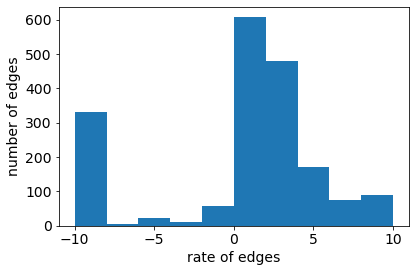

<ipython-input-7-5bb7197f5047>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


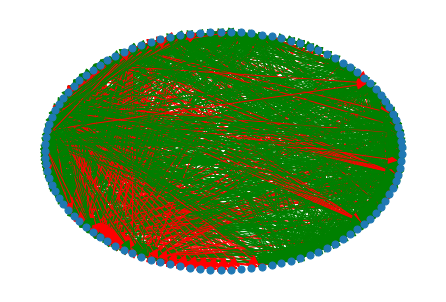

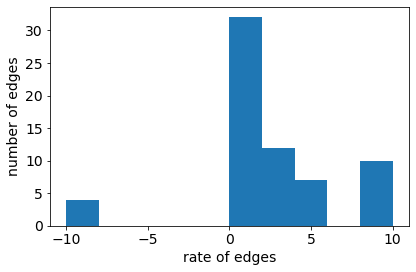

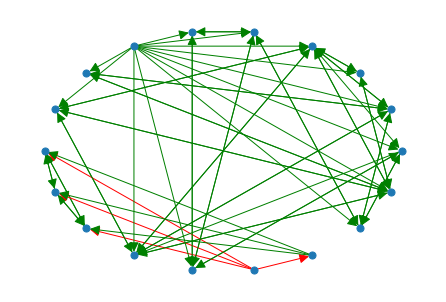

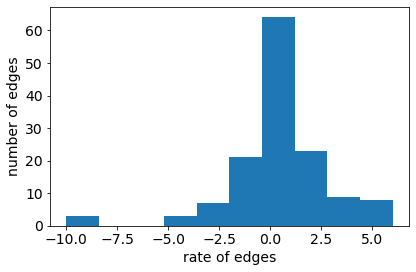

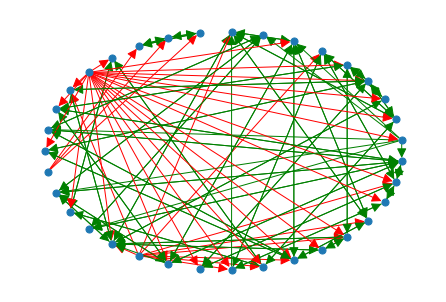

In [7]:
h_list = []
removed_nodes = []
pairs= [([list(i) for i in motif3[2][8]],1)]
for i in range(3):
#     print('!!', len(pairs[0][0]))
    node_d, fibheap = init_heap_and_dict(pairs)
    results = peel_by_motif(node_d, fibheap, pairs, 1, False)
    H = num_labeled_G.subgraph(results[1])
    removed_nodes += list(H.nodes)
    h_list.append(H)
    
    rates = nx.get_edge_attributes(H, "rate")
    value_list = list(rates.values())
    vs = plt.hist(value_list)
    plt.ylabel('number of edges')
    plt.xlabel('rate of edges')
    plt.tight_layout()
#     plt.savefig('figs/bitcoin_otc/contrast_9_10_hist'+str(i)+'.png')
    plt.show()
    
    colors = ['g' if H[u][v]['rate']>0 else 'r' for u,v in H.edges]
    nx.draw_shell(H, node_size=50, edge_color=colors, arrowsize=20)
    plt.tight_layout()
#     plt.savefig('figs/bitcoin_otc/contrast_9_10_shape'+str(i)+'.png')
    plt.show()
    
    new_pairs = []
    for pair in pairs:
        temp_motif_list = []
#         print(len(pair[0]))
        for motif in pair[0]:
#             print(motif)
            flag = 0
            for node in motif:
                
                if node in removed_nodes:
                    flag = 1
                    break
            if flag == 0:
                temp_motif_list.append(motif)
        new_pairs.append((temp_motif_list, pair[1]))
#         print(len(temp_motif_list))
    pairs = new_pairs

# Peel with favor of motifs with id 8 and 9, exclude motifs with id 10

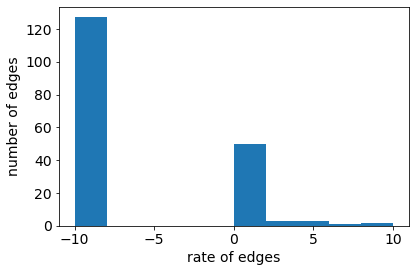

<ipython-input-26-33872eb6f9a7>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


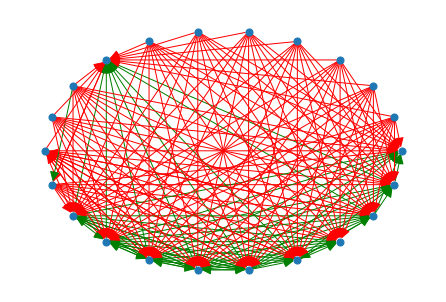

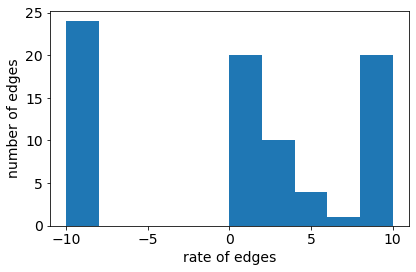

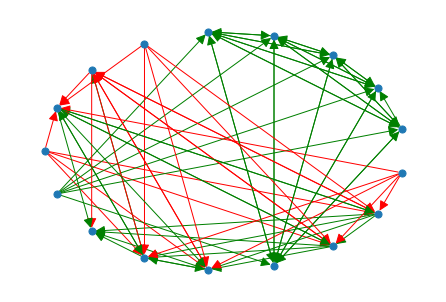

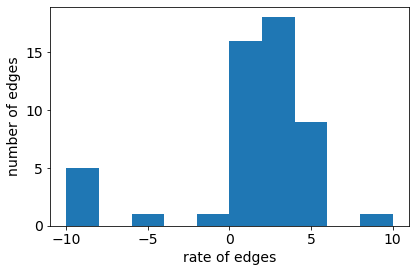

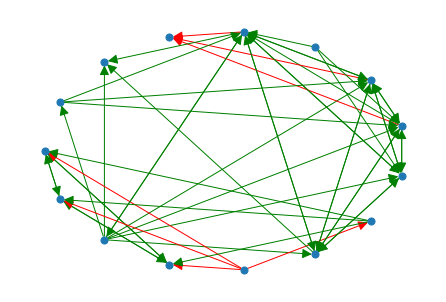

In [26]:
h_list = []
removed_nodes = []
pairs= [([list(i) for i in motif3[2][7]],1),([list(i) for i in motif3[2][8]],1),([list(i) for i in motif3[2][9]],-1)]
for i in range(3):
#     print('!!', len(pairs[0][0]))
    node_d, fibheap = init_heap_and_dict(pairs)
    results = peel_by_motif(node_d, fibheap, pairs, 1, False)
    H = num_labeled_G.subgraph(results[1])
    removed_nodes += list(H.nodes)
    h_list.append(H)
    
    rates = nx.get_edge_attributes(H, "rate")
    value_list = list(rates.values())
    vs = plt.hist(value_list)
    plt.ylabel('number of edges')
    plt.xlabel('rate of edges')
    plt.tight_layout()
    plt.savefig('figs/bitcoin_otc/contrast_8_9_10_hist'+str(i)+'.png')
    plt.show()
    
    colors = ['g' if H[u][v]['rate']>0 else 'r' for u,v in H.edges]
    nx.draw_shell(H, node_size=50, edge_color=colors, arrowsize=20)
    plt.tight_layout()
    plt.savefig('figs/bitcoin_otc/contrast_8_9_10_shape'+str(i)+'.png')
    plt.show()
    
    new_pairs = []
    for pair in pairs:
        temp_motif_list = []
#         print(len(pair[0]))
        for motif in pair[0]:
#             print(motif)
            flag = 0
            for node in motif:
                
                if node in removed_nodes:
                    flag = 1
                    break
            if flag == 0:
                temp_motif_list.append(motif)
        new_pairs.append((temp_motif_list, pair[1]))
#         print(len(temp_motif_list))
    pairs = new_pairs

# Another interesting motif pairs to contrast (4 and 13)

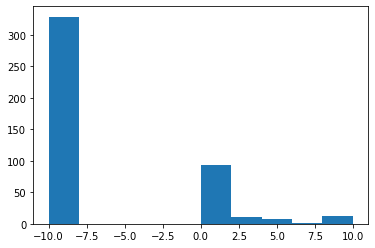

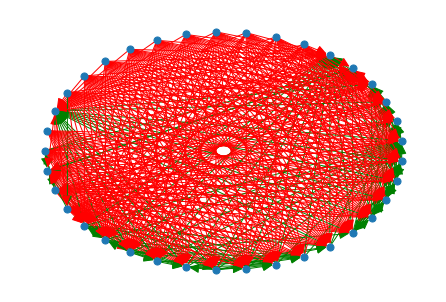

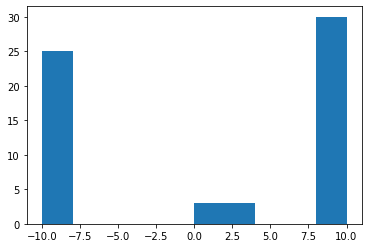

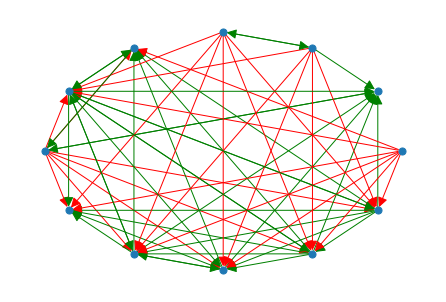

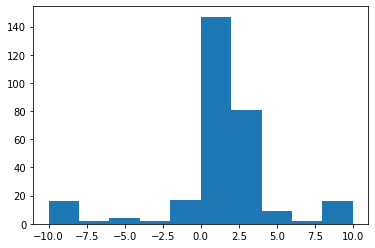

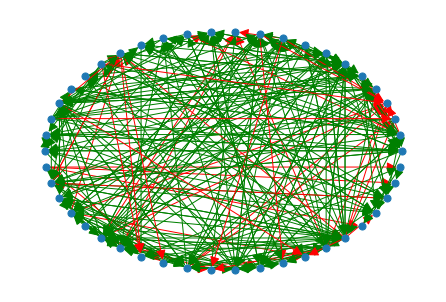

In [33]:
h_list = []
removed_nodes = []
pairs= [([list(i) for i in motif3[2][3]],1),([list(i) for i in motif3[2][12]],-1)]
for i in range(3):
#     print('!!', len(pairs[0][0]))
    node_d, fibheap = init_heap_and_dict(pairs)
    results = peel_by_motif(node_d, fibheap, pairs, 1, False)
    H = num_labeled_G.subgraph(results[1])
    removed_nodes += list(H.nodes)
    h_list.append(H)
    
    rates = nx.get_edge_attributes(H, "rate")
    value_list = list(rates.values())
    vs = plt.hist(value_list)
    plt.show()
    
    colors = ['g' if H[u][v]['rate']>0 else 'r' for u,v in H.edges]
    nx.draw_shell(H, node_size=50, edge_color=colors, arrowsize=20)
    plt.show()
    
    new_pairs = []
    for pair in pairs:
        temp_motif_list = []
#         print(len(pair[0]))
        for motif in pair[0]:
#             print(motif)
            flag = 0
            for node in motif:
                
                if node in removed_nodes:
                    flag = 1
                    break
            if flag == 0:
                temp_motif_list.append(motif)
        new_pairs.append((temp_motif_list, pair[1]))
#         print(len(temp_motif_list))
    pairs = new_pairs